# Classical and quantum dynamics of electrons in open stadium billiards

In [112]:
import kwant
import scipy
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal as sig

### Fundamental constants

In [2]:
h = 6.626069e-34    # Planck constant (Js)
h_ = h/(2*np.pi)
e = 1.602e-19      # electron charge (C)
c = 299792458       # Light celerity (m/s)
kB = 1.3806503e-23  # Boltzmann constant (kg m2/Ks2)
m_e = 9.1e-31       # electron mass (kg)

### Geometry of the device

In [3]:
"Equilateral triangle"
def equitriangle (side):
    def geom(pos):
        x, y = pos
        m1 = -1/np.sqrt(3)
        p1 = side/2
        m2 = 1/np.sqrt(3)
        p2 = -side/2
        return (x>=0 and x<side*np.sqrt(3)/2 and y>m2*x+p2 and y<m1*x+p1)
    return geom

"Square"
def square(sidelength) :
    def geom(pos):
        x, y = pos
        if x>=-sidelength/2 and x<sidelength/2 and y>=-sidelength/2 and y<sidelength/2:
            return True
        else:
            return False
    return geom

"Rectangle"
def rectangle(width, height):
    def geom(pos):
        x, y = pos
        if x>=-width/2 and x<width/2 and y>=-height/2 and y<height/2:
            return True
        else:
            return False
    return geom
    
"Circle"
def circle (radius) :
    def geom(pos):
        x, y = pos
        if (x**2+y**2<radius**2) :
            return True
        else:
            return False
    return geom

"Ring"
def ring(inner_radius, outer_radius):
    def geom(pos):
        x, y = pos
        r = np.sqrt(x**2 + y**2)
        return np.logical_and(inner_radius < r, r < outer_radius)
    return geom

    
"Stadium"
def stadium(length, radius):
    def geom(pos):
        x, y = pos
        return np.logical_or( np.logical_or((x-length/2)**2+y**2<(radius)**2, (x+length/2)**2+y**2<(radius)**2 ) , np.logical_and( np.abs(y)<radius, np.abs(x)<length/2) )
    return geom

## Parameters of the experiment

### Scaling

In [169]:
asquare = 0.5e-9 # [m] a is the lattice parameter
tsquare = 1.0 # [eV] t is the hopping parameter
scaling = 1 # scaling factor
"""scaling"""
a = asquare * scaling
t = tsquare / scaling**2

### Fermi energy, velocity and wavelength

In [189]:
"Fermi energy"
Ef = 0.3106*t   # Chosen Fermi energy [eV]
m = h_**2/(2*a**2*t) # Effective mass
k_F = np.sqrt(2*m*Ef/(h_**2)) # Wavevector
v_F = np.sqrt(2*Ef/m) # Fermi velocity

print("k_F = ", k_F)
print("E_F = ", Ef, "eV")
print("vF = ", v_F)
print("m* = ", m)

k_F =  1114629983.4474218
E_F =  0.3106 eV
vF =  5.284752343311447e+24
m* =  2.2242426650816416e-50


## Verifying of the conditions

In [190]:
""" The wavelength must be (much more) larger than the lattice parameter """
lambda_F2 = 2 * np.pi * a * np.sqrt(t / Ef) # computation of the wavelength
print("\lambda_F = ", lambda_F2)
if lambda_F/a < 2:
    print('Warning : lambda_F must be larger than the lattice parameter a')
    
""" The Fermi energy must be smaller than the hopping parameter t"""
print("E_F = ", Ef)
if Ef/t > 0.5:
    print('Warning : E_F must be smaller than the hopping parameter t')

\lambda_F =  5.637014435720111e-09
E_F =  0.3106


## Geometry of the leads

In [182]:
def lead_upper(width_lead):
    def geom(pos):
        x, y = pos
        return -width_leads/2 < x < width_leads/2
    return geom

#### Defining a zone of zero density in the sample

In [183]:
def onsite(site, Bfield, Vg):
    """
    Definition of the potential. To reach the bottom of the conduction band, the potential is set at 4*t.
    A zone of potential Vg (above the bottom of the conduction band) can be defined in a given zone. 
    """
#     return smooth_pot(site, effrad, radius, length, H) # 4*t +
    return 4*t

#### Defining a smooth potential

In [184]:
def smooth_pot(site, effrad, radius, length, H):
    def potential(pos):
        x, y = pos
        pot = np.zeros( len(x) )
        for i in np.arange( len(x) ) :
            if ( abs(y[i]) < radius and abs(x[i]) < length/2 ):
                pot[i] = H* (y[i]**2 -effrad**2) / (radius**2-effrad**2)
            elif ( x[i] > 0 ):
                pot[i] = H* ( (x[i]-length/2)**2+y[i]**2 -effrad**2 ) / (radius**2-effrad**2)
            elif ( x[i] < 0 ): 
                pot[i] = H* ( (x[i]+length/2)**2+y[i]**2 -effrad**2 ) / (radius**2-effrad**2)
            
            if ( (x[i]-length/2)**2+y[i]**2<effrad**2 or (x[i]+length/2)**2+y[i]**2<(effrad)**2 or ( np.abs(y[i])<effrad and np.abs(x[i])<length/2) ):
                pot[i] = 0
        return pot
    return potential

# def disorder(pos):
#     x, y = pos
#     print(x)
#     """ Change the definition of pot to include a smooth quadratic potential (a function of x and y)""" 
# #     pot = np.zeros( len(x) )
# #     for i in np.arange( len(x) ) :
# #         if ( abs(y[i]) < radius and abs(x[i]) < length/2 ):
# #             pot[i] = H* (y[i]**2 -effrad**2) / (radius**2-effrad**2)
# #         elif ( x[i] > 0 ):
# #             pot[i] = H* ( (x[i]-length/2)**2+y[i]**2 -effrad**2 ) / (radius**2-effrad**2)
# #         elif ( x[i] < 0 ): 
# #             pot[i] = H* ( (x[i]+length/2)**2+y[i]**2 -effrad**2 ) / (radius**2-effrad**2)

# #         if ( (x[i]-length/2)**2+y[i]**2<effrad**2 or (x[i]+length/2)**2+y[i]**2<(effrad)**2 or ( np.abs(y[i])<effrad and np.abs(x[i])<length/2) ):
# #             pot[i] = 0
#     return pot

#### The hopping parameter

In [185]:
def hopping(site_i, site_j, Bfield, Vg):
    xi, yi = site_i.pos
    xj, yj = site_j.pos  
    hop = t 
    return hop

### Building the system

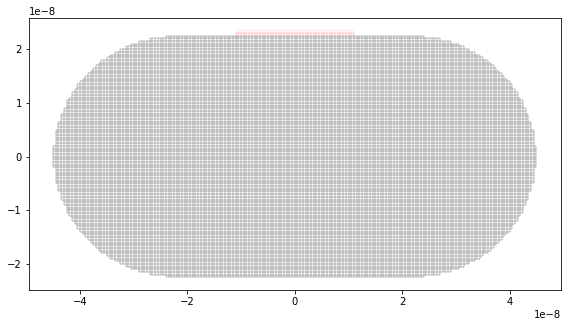

In [191]:
option_axes = 0
Bfield = 0 
Vg = 0
# Parameters 
# lambda_F = lambda_F2*(4.75/6)
lambda_F = lambda_F2
width_leads = lambda_F*4
radius = 4*lambda_F       # in [nm]
length = 2*radius    # distance between the two semicircles
coeff = 0.6
effrad = coeff*radius
H = 1             # Potential height on the contour (in [eV])

def sys_builder(a):
    
    lat = kwant.lattice.square(a, norbs = 1) # norbs gives the number of orbitals per atom. It is needed to compute J

    sys = kwant.Builder() 
    
    sys[lat.shape(stadium(length, radius), (0,0))] = onsite 
    
    sys[lat.neighbors()] = hopping 

    """ Lead 1 """
    sym1 = kwant.TranslationalSymmetry(lat.vec((0, 1)))
    lead1 = kwant.Builder(sym1)
    lead1[lat.shape(lead_upper(width_leads), (0,0))] = 4*t
    lead1[lat.neighbors()] = hopping
    """ The leads are attached """
    sys.attach_lead(lead1)

    sys = sys.finalized()
    
    return sys

"Building and plotting the system"
sys = sys_builder(a)

if (option_axes) :
    "Ajustement des axes en µm (seulement valable pour la cavité side = 3e-6)"
    axes = plt.gca()
    axes.set_xlim(0, 25e-7)
    axes.set_ylim(-15e-7, 15e-7)

    xlabels = ['-1','-0.5','0','0.5','1','1.5','2','2.5']
    ylabels = ['-2','-1.5','-1','-0.5','0','0.5','1','1.5','2']

    axes.set_xticklabels(xlabels)
    axes.set_yticklabels(ylabels)

    axes.axis('equal')
    kwant.plot(sys,ax=axes)
else :
    figure = kwant.plot(sys, site_size = 1e-9, fig_size = (10,5), lead_color = 'r')

In [62]:
# plt.figure()
# kwant.plotter.map(sys, )

# kwant_op = kwant.operator.Density(sys, sum=False)
# local_dos = kwant.kpm.SpectralDensity(sys, operator=kwant_op)
# zero_energy_ldos = local_dos(energy=0)

# print(sys[lat.shape(stadium(length, radius), (0,0))])

# sys.sites

ValueError: The number of sites doesn't match the number of provided values.

<Figure size 432x288 with 0 Axes>

### Computing the wave function

C:\Users\Leblanc\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: The plotted data contains 0.77% of values overflowing upper limit 0.808345 
  after removing the cwd from sys.path.


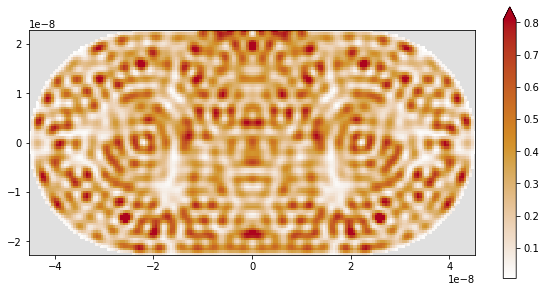

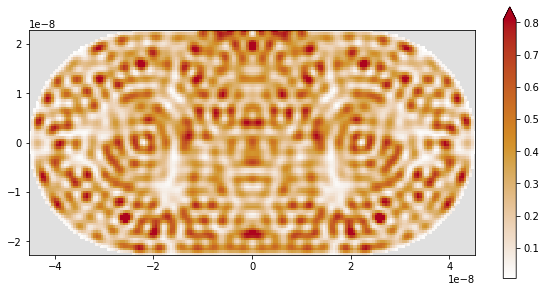

In [187]:
wfs = kwant.wave_function(sys, energy=Ef, params=dict(Bfield = Bfield, Vg=Vg)) 
scattering_wf = wfs(0)  
proba = sum(abs(scattering_wf)**2)
kwant.plotter.map(sys, proba, fig_size = (10,5))
# kwant.plotter.map(sys, abs(scattering_wf[0])**2, fig_size = (10,5))

### Observing recurences 

C:\Users\Leblanc\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: The plotted data contains 1.12% of values overflowing upper limit 1.70299 
  if __name__ == '__main__':


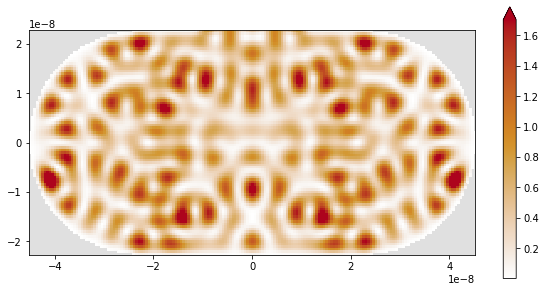

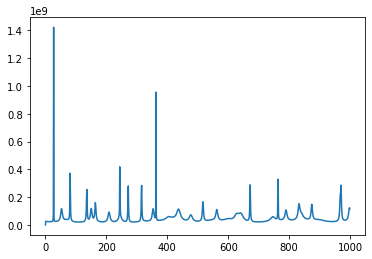

In [174]:
# Reference scars pattern for the correlation
wfs = kwant.wave_function(sys, energy=0.12*t, params=dict(Bfield = Bfield, Vg=Vg))
scattering_wf = wfs(0)  
proba = sum(abs(scattering_wf)**2)
N = len(proba)
fft_ref = np.fft.fft(proba)
std_ref = np.sqrt( sum( (proba-np.mean(proba))**2))
width = proba.shape
kwant.plotter.map(sys, proba, fig_size = (10,5))
# kwant.plotter.map(sys, abs(scattering_wf[0])**2, fig_size = (10,5))

# Comparing the pattern with the ones for other energies
n_subplots = 1000
energies = np.linspace(0.1*t, 0.15*t, n_subplots)
corrvals = np.zeros((n_subplots, 1))

for i in range(1, n_subplots):
    E = energies[i]
    wfs = kwant.wave_function(sys, energy=E, params=dict(Bfield = Bfield, Vg=Vg)) # the wave function is obtained by giving the parameters in arguments   
    scattering_wf = wfs(0) 
    probnow = sum(abs(scattering_wf)**2)
    fft_now = np.fft.fft(probnow)
    std_now = np.sqrt( sum( (probnow-np.mean(probnow))**2 ) )
    corrvals[i] = np.sum( np.abs(np.fft.ifft(fft_ref*fft_now))) 
#     /(std_ref*std_now)
#     kwant.plotter.map(sys, sum(abs(scattering_wf)**2), fig_size = (10,5)) # to map the wave function
plt.show()

# print(corrvals)
plt.figure()
plt.plot(corrvals)

### Computing and plotting the current density

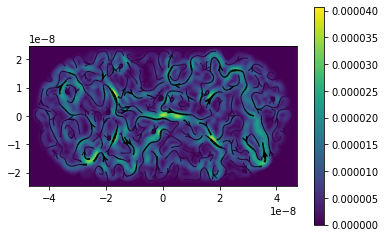

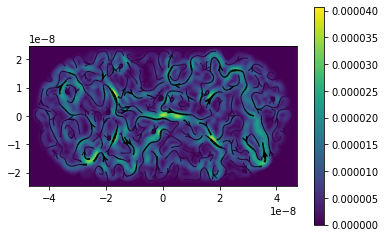

In [68]:
J0 = kwant.operator.Current(sys)
wf_left = wfs(0)
current = sum(J0(p, params=dict(Bfield=Bfield, Vg=Vg)) for p in wf_left) # to sum over all the lead's mode

kwant.plotter.current(sys, current, cmap='viridis')